In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
%matplotlib inline

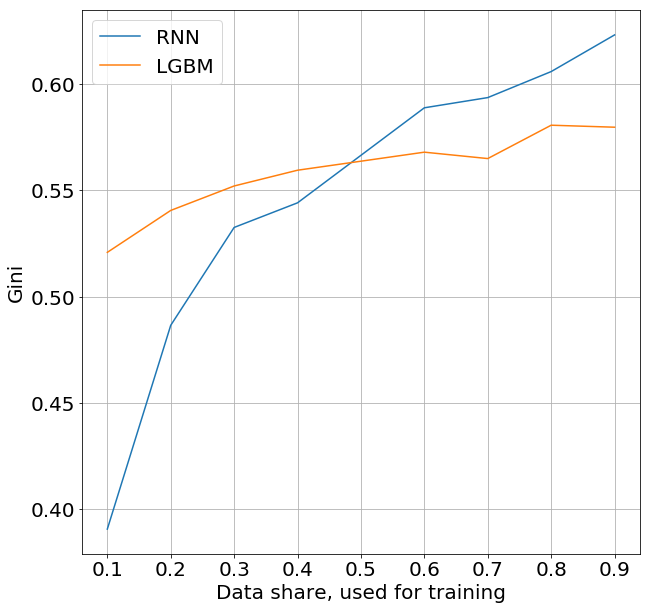

In [4]:
import matplotlib as mpl
mpl.rcParams.update({'font.size':20})

rnn_lc = pd.read_csv('data/rnn-learning-curve.csv', index_col='Data share, used for training', squeeze=True, header=None, names=['Data share, used for training', 'RNN'])
lgbm_lc = pd.read_csv('data/lgbm-learning-curve.csv', index_col='Data share, used for training', squeeze=True, header=None, names=['Data share, used for training', 'LGBM'])
lc = pd.DataFrame([rnn_lc, lgbm_lc]).T
lc= 2*lc-1
ax = lc.plot(figsize=(10,10), grid=True)
ax.set_ylabel('Gini')
None

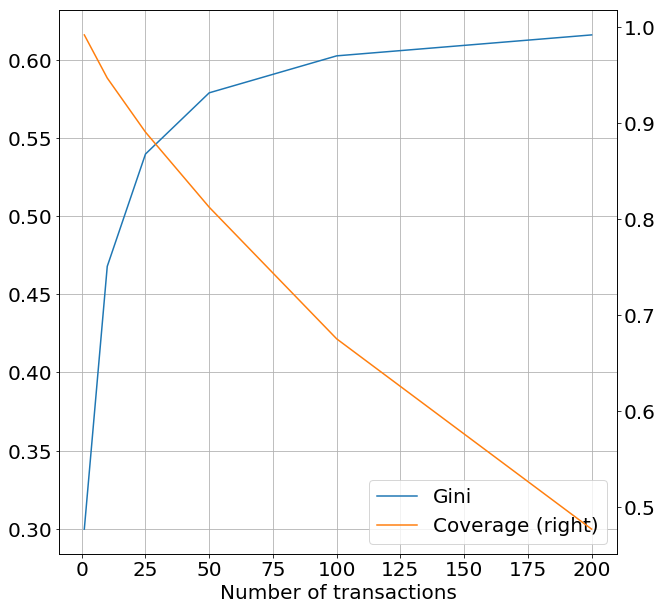

In [6]:
import matplotlib as mpl
mpl.rcParams.update({'font.size':20})

lc = pd.read_csv('data/rnn-auc-per-ntranz-single-model-cut.csv', index_col='min_tranz')
lc['Coverage'] = 1 - lc.share
lc['auc'] = 2*lc['auc']-1
lc = lc.drop([400, 800]).rename(columns={'auc': 'Gini'}).drop('share', axis=1)
lc.index.names = ['Number of transactions']
lc.plot(figsize=(10,10), secondary_y=['Coverage'], grid=True)
None

In [6]:
stats = pd.read_json('article-stats.json').query('n_epoch == 10 and ensemble_size in (1, 3, 6, 12)')

In [7]:
tl = stats.metrics.map(lambda e: e['valid_auc'])
tl_es = [(i, e, es) for l, es in zip(tl.tolist(), stats.ensemble_size) for i, e in enumerate(l)]
tl_df = pd.DataFrame(tl_es, columns=['epoch', 'loss', 'ens_size'])

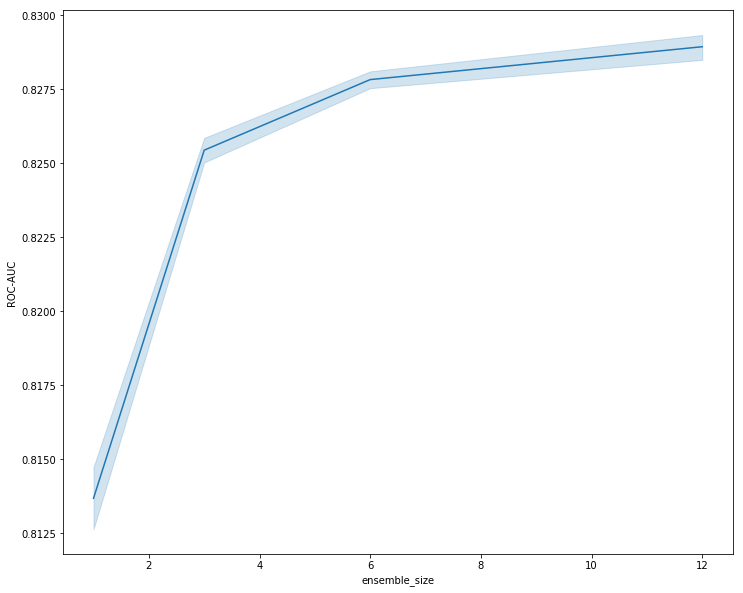

In [8]:
with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(12,10))
    sns.lineplot(x="ensemble_size", y="ROC-AUC", data=stats, legend="full")

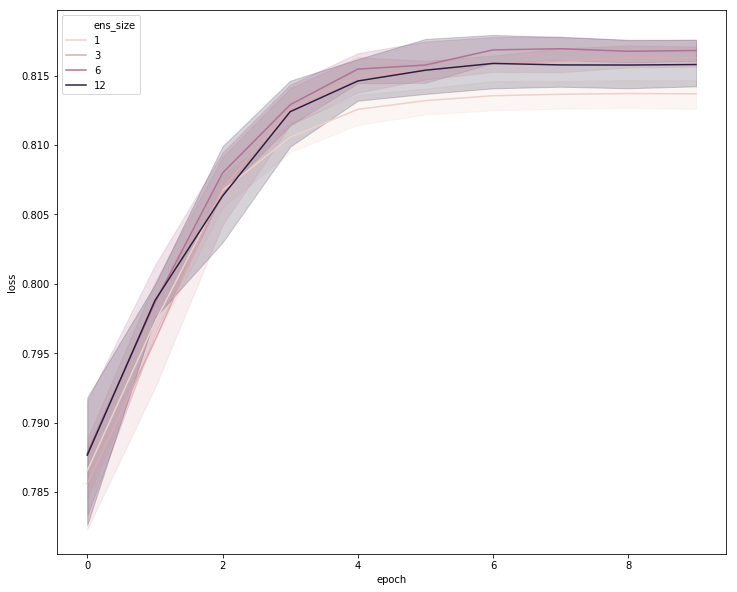

In [9]:
with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(12,10))
    sns.lineplot(x="epoch", y="loss", hue="ens_size", data=tl_df, legend="full")

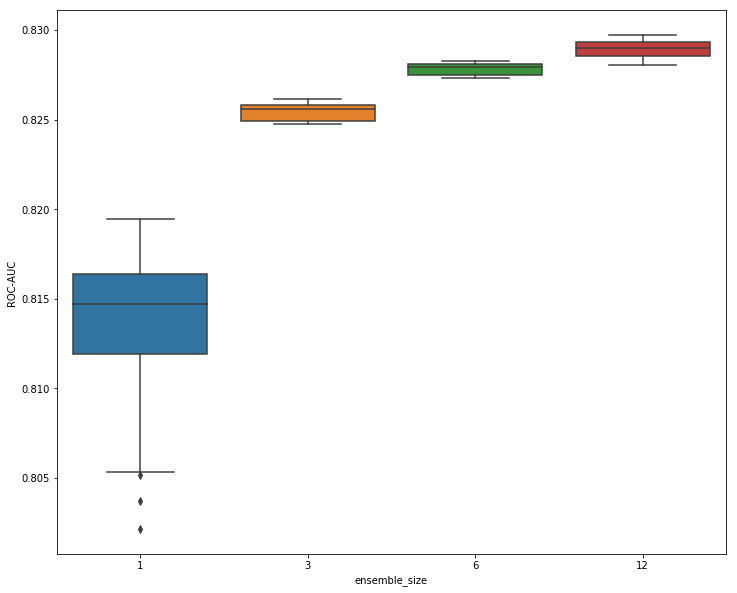

In [10]:
with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(12,10))
    sns.boxplot(x="ensemble_size", y="ROC-AUC", data=stats)